 # 아이템 기반 최근접 이웃 협업 필터링 실습

> 데이터 가공 및 변환

In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/movies.csv")
ratings = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings.csv")

print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- pivot_table 함수

: 아래와 같은 코드 사용하면, 로우는 userid / 칼럼은 movieid / 데이터는 rating에 있는 값이 각각 로우와 칼럼에 맞게 들어감

: nan이 많음 -> 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 nan값으로 할당됐기 때문. 최소 평점이 0.5이므로 nan은 모두 0으로 변환

In [6]:
ratings = ratings[["userId","movieId","rating"]]

ratings_matrix = ratings.pivot_table("rating",index="userId",columns="movieId")

ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on="movieId")

# columns="title"로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table("rating",index="userId", columns="title")

In [12]:
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> ### 영화 간 유사도 산출

- cosine_similarity()함수는 기준행과 타 행을 비교하여 유사도 산출 

  -> 영화를 기준으로 적용하려면 행 기준이 영화가 되고, 열 기준이 사용자가 돼야 함 

In [13]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환

item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, 
                          columns=ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


: 9719 로우인 ratings_matrix.transpose()데이터 세트에 대해 cosine_similarity()를 적용한 결과 9719 x 9719 shape으로 영화의 유사도 행렬인 item_sim이 생성 

In [18]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [19]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

> ### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

<br>
앞 예제에서 만든 아이템 기반의 영화 유사도 데이터는 모든 사용자의 평점을 기준으로 영화의 유사도를 생성했고, 이를 이용해 훌륭한 영화를 추천할 수 있었습니다. 하지만 이는 개인적인 취향을 반영하지 않고 영화 간의 유사도만을 가지고 추천한 것입니다. 이번 절에서는 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천을 구현해보겠습니다 

-> 개인화된 영화 추천의 가장 큰 특징은 개인이 아직 관람하지 않은 영화를 추천한다는 것입니다. 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천하는 방식입니다

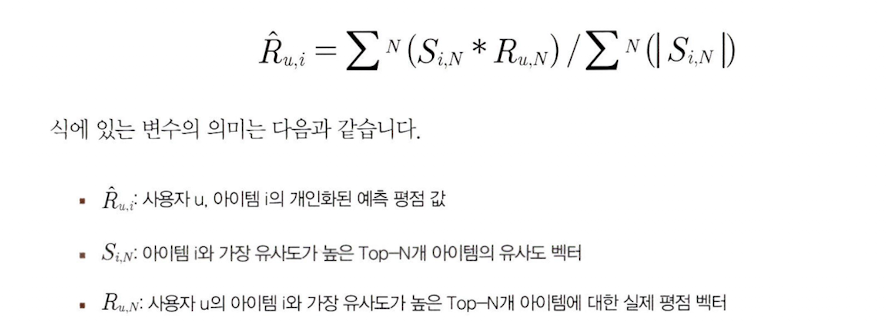

In [20]:
from IPython.display import Image
Image("/Users/ijiseon/Desktop/개인화된 예측평점.png")

- 여기에서 S와 R에 나오는 N 값은 아이템의 최근접 이웃 범위 계수를 의미합니다. 이는 특정 아이템과 유사도가 가장 높은 top-n 개의 다른 아이템을 추출하는 데 사용됩니다. 먼저 n의 범위에 제약을 두지 않고 모든 아이템으로 가정하고 예측 평점을 구하는 로직을 작성한 뒤에 top-n개 아이템을 기반으로 협업 필터링을 수행하는 로직으로 변경하겠습니다

- 앞 예제에서 생성된 영화 간의 유사도를 가지는 DataFrame인 item_sim_df와 사용자-영화 평점 DataFrmae인 ratings_matrix 변수를 계속 활용해 사용자별로 최적화된 평점 스코어를 예측하는 함수를 만들겠습니다. 함수 명은 predict_rating()이며, 인자로 사용자-영화 평점 넘파이 행렬과 영화 간의 유사도를 가지는 넘파이 행렬을 입력받고 이를 이용해 개인화된 예측 평점을 계산 

- 사용자별 영화 예측 평점 R은 사용자 u의 모든 영화에 대한 실제 평점과 영화 i의 다른 모든 영화와의 코사인 유사도를 벡터 내적 곱한 값을 정규화를 위해 합S로 나눈 것을 의미 

In [21]:
def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array(([np.abs(item_sim_arr).sum(axis=1)]))
    return ratings_pred

In [24]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)

ratings_pred_matrix= pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                 columns=ratings_matrix.columns)

In [27]:
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


: 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존에 영화를 관람하지 않아 0에 해당하던 실제 영화평점이 예측에서는 값이 부여되는 경우가 많이 발생합니다.

: 예측 평점이 실제 평점에 비해 작을 수 있습니다 이는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상입니다 

In [29]:
from sklearn.metrics import mean_squared_error

#사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred,actual):
    #평점이 있는 실제 영화만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred,actual)

In [31]:
print("아이템 기반 모든 최근접 이웃 MSE:", get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


앞의 predict_rating()함수는 사용자별 영화의 예측 평점을 계산하기 위해 해당 영화와 다른 모든 영화 간의 유사도 벡터를 적용한 것입니다. 많은 영화의 유사도 벡터를 이용하다 보니 상대적으로 평점 예측이 떨어졌습니다. 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경하겠습니다

In [32]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    #사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    #사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
    for col in range(ratings_arr.shape[1]):
        #유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:,col])[:-n-1:-1]]
        #개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row,col] = item_sim_arr[col,:][top_n_items].dot(ratings_arr[row,:][top_n_items].T)
            pred[row,col] /= np.sum(np.abs(item_sim_arr[col,:][top_n_items]))
            
    return pred     

In [34]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

print("아이템 기반 Top-20 이웃 MSE:", get_mse(ratings_pred, ratings_matrix.values))

/var/folders/f4/skyf3wfx5570p30yjkrfkxd00000gn/T/ipykernel_64000/4095029881.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[row,col] = item_sim_arr[col,:][top_n_items].dot(ratings_arr[row,:][top_n_items].T)


아이템 기반 Top-20 이웃 MSE: 3.695094143046059


In [38]:
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

#userid=9인 사용자에 대해 영화를 추천
user_rating_id = ratings_matrix.loc[9,:]
user_rating_id[user_rating_id>0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Austin Powers in Goldmember (2002)                                                5.0
Back to the Future (1985)                                                         5.0
Citizen Kane (1941)                                                               5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Producers, The (1968)                                                             5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Elling (2001)                                                                     4.0
King of Comedy, The (1983)                                                        4.0
Name: 9, dtype: float64

In [44]:
# 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수인 get_unseen_movies()를 생성

def get_unseen_movies(ratings_matrix, userId):
    
    #userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환
    #반환된 user_rating은 영화명 (title)을 인덱스로 가지는 Series 객체임
    user_rating = ratings_matrix.loc[userId,:]
    
    #user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦
    already_seen = user_rating[user_rating>0].index.tolist()
    
    #모든영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()
    
    #list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
    unseen_list = [movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [45]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [46]:
unseen_list = get_unseen_movies(ratings_matrix,9)

recomm_movies = recomm_movie_by_userid(ratings_pred_matrix,9,unseen_list, top_n=10)

In [50]:
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, 
                             columns=["pred_score"])

recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


## 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

R은 원본 사용자 - 아이템 평점 행렬이며, K는 잠재 요인의 차원 수

In [10]:
def matrix_factorization(R,K,steps=200, learning_rate=0.01, r_lambda=0.01):
    num_users, num_items = R.shape
    
    # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력합니다.
    P = np.random.normal(scale=1./K, size=(num_users,K))
    Q = np.random.normal(scale=1./K, size=(num_items,K))
    
    prev_rmse = 10000
    break_count = 0
    
    # R>0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
    non_zeros = [(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0 ]
    
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i,j,r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i,:],Q[j,:].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij*Q[j,:]-r_lambda*P[i,:]) 
            Q[j,:] = Q[j,:] + learning_rate*(eij*P[i,:]-r_lambda*Q[j,:])
            
        rmse = get_rmse(R,P,Q,non_zeros)
        if (step%10)==0:
            print("### iteration step : ", step, "rmse: ", rmse)
            
    return P, Q

In [57]:
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q,non_zeros):
    error = 0
    # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P,Q.T)
    
    #실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [53]:
movies = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/movies.csv")
ratings = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings.csv")
ratings = ratings[["userId", "movieId","rating"]]
ratings_matrix = ratings.pivot_table("rating", index ="userId", columns="movieId")

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on="movieId")

# columns = "title"로 title 칼럼으로 pivot 수행 
ratings_matrix = rating_movies.pivot_table("rating", index="userId", columns="title")

In [58]:
# 다시 만들어진 사용자 - 아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해

P,Q = matrix_factorization(ratings_matrix.values ,K=50, steps=200, learning_rate=0.01,
                          r_lambda = 0.01)

pred_matrix = np.dot(P,Q.T)

### iteration step :  0 rmse:  2.953842446323677
### iteration step :  10 rmse:  0.7294431135441936
### iteration step :  20 rmse:  0.5100104529964781
### iteration step :  30 rmse:  0.3711563992100183
### iteration step :  40 rmse:  0.29472795919075667
### iteration step :  50 rmse:  0.2512130101185821
### iteration step :  60 rmse:  0.22450721397192003
### iteration step :  70 rmse:  0.20676912464095068
### iteration step :  80 rmse:  0.19418356397128372
### iteration step :  90 rmse:  0.18478226297890313
### iteration step :  100 rmse:  0.17747979357761468
### iteration step :  110 rmse:  0.17163718493297572
### iteration step :  120 rmse:  0.16685467096962087
### iteration step :  130 rmse:  0.16286852868749113
### iteration step :  140 rmse:  0.15949697340140914
### iteration step :  150 rmse:  0.15661014370210727
### iteration step :  160 rmse:  0.15411252299809883
### iteration step :  170 rmse:  0.15193213641783085
### iteration step :  180 rmse:  0.15001363333664508
### iterat

In [59]:
ratings_pred_matrix = pd.DataFrame(pred_matrix, index=ratings_matrix.index,  
                                   columns=ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.015267,4.044242,3.539785,4.710998,4.296567,1.179727,3.50384,2.330604,3.867963,4.024221,...,1.382111,4.641960,3.787472,2.831106,2.796532,4.583734,2.992980,2.021206,3.944466,0.891225
2,3.067306,3.505912,3.175292,4.315275,4.277333,1.196527,3.84252,1.781695,3.609804,3.582275,...,0.986019,3.977232,3.219468,2.667706,2.413799,3.658328,3.051554,1.750698,3.925383,0.817981
3,2.331071,2.087635,1.799794,2.243707,2.580322,0.569462,1.34104,1.420152,1.478961,2.200475,...,0.575095,1.775162,1.840643,1.861177,1.566701,2.042523,2.754015,0.964090,3.489919,0.572985


In [60]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix,9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성 
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                            columns=["pred_score"])

recomm_movies

,pred_score
title,
Highlander (1986),5.355417
This Is Spinal Tap (1984),5.348877
Austin Powers: The Spy Who Shagged Me (1999),5.335748
Michael Clayton (2007),5.289104
"Grand Budapest Hotel, The (2014)",5.283064
"Lord of the Rings: The Return of the King, The (2003)",5.198546
Blade Runner (1982),5.099870
"Clockwork Orange, A (1971)",5.073262
Run Lola Run (Lola rennt) (1998),5.021491


# 파이썬 추천 시스템 패키지 - Surprise

In [1]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
data = Dataset.load_builtin("ml-100k")

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /Users/ijiseon/.surprise_data/ml-100k


In [4]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

In [5]:
algo = SVD()
algo.fit(trainset)

#### Surprise에서 추천을 예측하는 메서드

- test() <br>
  : 사용자-아이템 평점 데이터 세트 전체에 대해서 추천을 예측하는 메서드. 즉 입력된 데이터 세트에 대해 추천 데이터 세트를 만들어 줍니다. predict()는 개별 사용자와 영화에 대한 추천 평점을 반환해줍니다 

- predict() <br> 
  : 개별 사용자와 영화에 대한 추천 평점을 반환해 줍니다  

> test()

In [6]:
predictions = algo.test(testset)
print("prediction type: ", type(predictions), "size: ", len(predictions))
print("prediction 결과의 최초 5개 추출")
predictions[:5]

prediction type:  <class 'list'> size:  25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.8696675467641697, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=4.037623794983772, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.000676280358962, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.7707317318172384, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.3431879417421193, details={'was_impossible': False})]

: SVD 알고리즘 객체의 test 메서드의 호출 결과는 파이썬 리스트이며 크기는 입력 인자 데이터 세트의 크기와 같은 25,000개입니다 <br>
: 호출 결과로 반환된 리스트 객체는 25,000개의 Prediction 객체를 내부에 가지고 있습니다.<br>
: Prediction 객체는 Surprise 패키지에서 제공하는 데이터 타입이며, 개별 사용자 아이디, 영화 아이디와 실제 평점 정보에 기반해 Surprise의 추천 예측 평점(est) 데이터를 튜플 형태로 가지고 있습니다. <br>
: Prediction 객체의 details 속성은 내부 처리 시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는 데 사용됩니다. was_impossible이 True이면 예측값을 생성할 수 없는 데이터라는 의미

In [7]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.8696675467641697),
 ('882', '291', 4.037623794983772),
 ('535', '507', 4.000676280358962)]

> predict()

In [8]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid,iid)
print(pred) 

user: 196        item: 302        r_ui = None   est = 4.26   {'was_impossible': False}


결과처럼 predict()는 개별 사용자와 아이템 정보를 입력하면 추천 예측 평점을 est로 반환합니다. test()메서드는 입력 데이터 세트의 모든 사용자와 아이템 아이디에 대해서 predict()를 반복적으로 수행한 결과라고 생각하면 좀 더 이해하기 쉬울 것

In [9]:
accuracy.rmse(predictions)

RMSE: 0.9495


0.9494817999391015

> #### Surprise - Dataset

In [11]:
import pandas as pd

ratings = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings.csv")
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [12]:
#ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings_noh.csv", index=False, header=False)

In [14]:
from surprise import Reader

reader = Reader(line_format="user item rating timestamp", sep=",", rating_scale=(0.5,5))
data = Dataset.load_from_file("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings_noh.csv", reader=reader)

In [16]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

#잠재 요인 크기 K 값을 나타내는 파라미터 n_factors
algo = SVD(n_factors=50, random_state=0)

algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

In [18]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings.csv")
reader = Reader(rating_scale=(0.5,5.0))

#ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

> ### 베이스라인 평점

<br>

베이스라인 평점 = 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수

- 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값
- 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
- 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

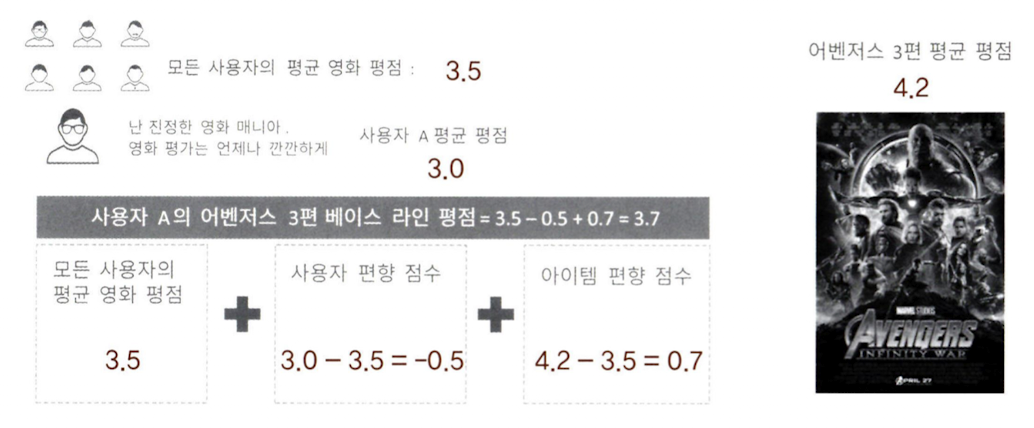

In [19]:
from IPython.display import Image
Image("/Users/ijiseon/Desktop/베이스라인.png")

- 교차 검증과 하이퍼 파라미터 튜닝

In [20]:
from surprise.model_selection import cross_validate

ratings = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings.csv")
reader = Reader(rating_scale=(0.5,5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId","rating"]],reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=["RMSE","MAE"],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8766  0.8733  0.8709  0.8735  0.8732  0.8735  0.0018  
MAE (testset)     0.6715  0.6725  0.6719  0.6701  0.6705  0.6713  0.0009  
Fit time          0.88    0.83    1.05    0.86    0.87    0.90    0.08    
Test time         0.15    0.20    0.11    0.16    0.08    0.14    0.04    


{'test_rmse': array([0.87662226, 0.87331134, 0.87086865, 0.87346573, 0.87315005]),
 'test_mae': array([0.67147893, 0.67253912, 0.67188216, 0.67006656, 0.67052916]),
 'fit_time': (0.881972074508667,
  0.8317289352416992,
  1.0507750511169434,
  0.8638589382171631,
  0.8697378635406494),
 'test_time': (0.1545720100402832,
  0.20025300979614258,
  0.10912394523620605,
  0.15932297706604004,
  0.08201098442077637)}

In [22]:
from surprise.model_selection import GridSearchCV

param_grid = {"n_epochs":[20,40,60], "n_factors":[50,100,200]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse","mae"],cv=3)
gs.fit(data)

In [23]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.877981511578881
{'n_epochs': 20, 'n_factors': 50}


- ### Surprise를 이용한 개인화 영화 추천 시스템 구축

In [24]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생

data = Dataset.load_from_df(ratings[["userId","movieId","rating"]],reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

-> 데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스를 이용하면 됨 

In [25]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format="user item rating timestamp", sep=",", rating_scale=(0.5,5))

# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file="/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/ratings_noh.csv", reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

- DatasetAutoFolds의 build_full_trainset()메서드를 이용해 생성된 학습 데이터를 기반으로 학습을 수행하겠습니다 

- 특정 사용자는 userid=9인 사용자로 지정 > 아직 보지 않은 영화 moiveid 42로 선정한 뒤 예측 평점을 계산

In [26]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [28]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv("/Users/ijiseon/Desktop/ESAA-OB/ml-latest-small/movies.csv")

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings["userId"]==9]["movieId"]

if movieIds[movieIds==42].count() ==0:
    print("사용자 아이디 9는 영화 아이디 42의 평점 없음")
    
print(movies[movies["movieId"]==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [29]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


추천 예측 평점은 est 값으로 3.13입니다. 사용자가 평점을 매기지 않은 영화의 추천 예측 평점을 간단하게 구하는 방법을 알았으니 이제 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤에 예측 평점 순으로 영화를 추천해보겠습니다. 

먼저 추천 대상이 되는 영화를 추출하겠습니다. Surprise 내부의 데이터 객체에 대한 엑세스 제약 등으로 인해 앞 절에서 사용한 get_unseen_movies()는 사용하지 않고 새롭게 get_unseen_surprise()함수를 만들고 이를 이용해 아이디 9인 사용자가 아직 평점을 매기지 않은 영화 정보를 반환합니다

In [35]:
def get_unseen_surprise(ratings, movies, userId):
    # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings["userId"]==userId]["movieId"].tolist() 
    # 모든 영화의 movieId를 리스트로 생성
    total_movies = movies["movieId"].tolist()
    
    # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print("평점 매긴 영화 수:", len(seen_movies), " 추천 대상 영화 수:",len(unseen_movies), 
         "전체 영화 수:",len(total_movies))
    
    return unseen_movies

In [33]:
ratings["userId"]==9

0         False
1         False
2         False
3         False
4         False
          ...  
100831    False
100832    False
100833    False
100834    False
100835    False
Name: userId, Length: 100836, dtype: bool

In [36]:
unseen_movies = get_unseen_surprise(ratings,movies,9)

평점 매긴 영화 수: 46  추천 대상 영화 수: 9696 전체 영화 수: 9742


In [49]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]
    
    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음
    
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행
    def sortkey_est(pred):
        return pred.est
    
    # sortkey_est() 반환값의 내림차순으로 정렬 수행하고 top_n개의 최상위 값 추출
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions = predictions[:top_n]
    
    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [int(pred.iid) for pred in top_predictions]
    top_movie_rating = [pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]["title"]
    
    top_movie_preds = [(id, title, rating) for id, title, rating in \
                      zip(top_movie_ids, top_movie_titles, top_movie_rating)]
    
    return top_movie_preds

In [50]:
unseen_movies = get_unseen_surprise(ratings,movies,9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

평점 매긴 영화 수: 46  추천 대상 영화 수: 9696 전체 영화 수: 9742


In [51]:
print("#### Top-10 추천 영화 리스트 ####")

for top_movie in top_movie_preds:
    print(top_movie[1],":",top_movie[2])

#### Top-10 추천 영화 리스트 ####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122758
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122658
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
